# Evolving Neural Networks in JAX
## Scaling CMA-ES with the Power of ` vmap` and `jit`

"So why should I switch from `<insert-autodiff-library>` to JAX?". The classic first passive-aggressive question when talking about the new 'kid on the block'. Here is my answer: JAX is not simply a fast library for automatic differentiation. If your scientific computing project wants to benefit from XLA, JIT-compilation and the bulk-array programming paradigm -- then JAX provides a wonderful API. While PyTorch relies on pre-compiled kernels and fast C++ code for most common Deep Learning applications, JAX allows us to leverage a high-level interface for programming your favorite accelerators. `vmap`, `pmap`, `jit` accelerate and vectorize across array dimensions/compute devices without having do deal with asynchronous bookkeeping of processes. But this is not restricted to standard gradient-based optimization setups. It also applies to many evolutionary methods. Therefore, in this post we explore how JAX can power the next generation of scalable neuroevolution algorithms:

1. We will walk through the Covariance Matrix Adaptation Evolution Strategies (CMA-ES, e. g. [Hansen, 2016](https://arxiv.org/abs/1604.00772)) and discuss challenges such as the 'curse of dimensionality' and the statistical estimation of high-dimensional covariance matrices.
2. We will implement the CMA-ES update equations in JAX. We will show how get the most out of `vmap` and vectorize over two crucial dimensions of ES: The generation population size and the number of fitness evaluations per population member.
3. We will evolve a feedforward policy to balance a Pendulum using CMA-ES. Afterwards, we explore different hyperparameters (neural network size, mean learning rate and degree of selection) to get a better intuition for key trade-offs in ES.
4. Finally, we will analyze run and compilation times for CMA-ES generation iterations and across different hardware platforms. We will see that XLA-compilation and vectorization of `vmap` smoothly scales on different platforms (CPU/different GPUs).

> *TL;DR*: JAX is awesome for scaling neuroevolution algorithms. We can `vmap` over both the parametrization of all population members and their stochastic fitness evaluations. By eliminating multiprocessing/MPI communication shenanigans, we can run neuroevolution experiments on modern accelerators (GPU/TPU) and almost zero engineering overhead. If you want to learn how this looks like for CMA-ES, come along for a ride.

**Note**: Throughout the post we will assume that you already know the basic primitives of JAX such as `jit`, `vmap` and `lax.scan`. If you feel like you need to catch up on these, checkout the [JAX quickstart guide](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) or my [JAX intro blog post](https://roberttlange.github.io/posts/2020/03/blog-post-10/). 

Let's start by installing and importing a couple of packages.

In [1]:
try:
    import jax
except:
    !pip install --upgrade jax
    !pip install --upgrade jaxlib

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
from jax import jit, vmap, lax
import functools, time
import matplotlib.pyplot as plt

# Evolutionary Strategies and the Ask-Evaluate-Tell API

Evolutionary strategies aim to minimize a black-box function without the use of explicit analytical derivatives or gradient estimates. Instead, they rely on stochastic evaluations of the (potentially noisy) function of interest $f: \mathbb{R}^d \to \mathbb{R}$. The previously accumulated information is then cleverly integrated to inform the search distribution $\pi(\cdot)$. Th sequential batches of proposal solutions $x_i^{(g)} \in \mathbb{R}^d, i=1,\dots,N$ are also known as **individuals of a generation** $g$. In neuroevolution $x$ corrsponds to the parameters of a neural network and $f(.)$ denotes some metric of performance. Importantly, we are not relying on backprop and the resulting gradients, the objective does not have to be smooth and differentiable. This has a couple of practical implications:

1. We have a lot **more freedom to design neural networks**. Most common deep learning building blocks such as convolutional, linear and attention layers are designed with gradient descent in the back of our mind. But if we don't need gradients to learn, we could use non-differentiable non-linearities such as spike and threshold-based activations.
2. We don't have to carefully handcraft objective functions, which support the learning dynamics prescribed by gradient descent. Instead, we **can directly optimize the function of interest**. E.g. in RL we can directly aim to maximize the episode return without the need for surrogate objectives such as the mean squared Bellman error.
3. Instead of optimizing a single point estimate of the solution parameters, ES keep a **a search distribution over solutions**. This surrogate of the objective landscape can be used to sample solutions, which may be diverse in how they solve a task. This heterogeneity can for example be used to ensemble predictions.

ES can be thought of as search algorithms, which use a type of memory or **surrogate model** of the objective. The specific form of the surrogate $\pi_\theta$ differs across ES (e.g. for CMA-ES it will be a scaled multivariate Gaussian). The general procedure has three repeating steps:

![es_schema](img/es_schema.png)

1. **Ask**: Given the current surrogate model, we "ask" for a set of evaluation candidates or a new generation, $x \sim \pi_\theta(\cdot)$.
2. **Evaluate**: We evaluate the fitness of each member $x_i$ in the proposed generation using the objective $f(\cdot)$, which returns a "utility" scalar. For stochastic objectives we potentially have to do so multiple times to obtain a reliable fitness estimate.
3. **Tell**: Next, we use $(x, f(x))$ to update the model $\theta \to \theta'$. The search distribution will be adjusted to increase the likelihood of well performing candidates. This update specifies how to cope with the *exploration-exploitation* trade-off.

We iterate over these three steps for a set of generations $g = 1, \dots, G$. This three-step procedure is commonly implemented in hyperparameter optimisation toolboxes (e.g. [`scikit-optimize`](https://scikit-optimize.github.io/stable/auto_examples/parallel-optimization.html#sphx-glr-auto-examples-parallel-optimization-py)) and provides a minimal minimal API for interfacing with ES (e.g. see [David Ha's blog](https://blog.otoro.net/2017/10/29/visual-evolution-strategies/)). 

# The CMA-ES & Its Update Rules
## ... and how to implement them in JAX

In CMA-ES the search distribution $\pi_\theta$ is a multivariate Gaussian with mean $m \in \mathbb{R}^d$ and scaled covariance matrix $\sigma^2 \cdot C \in \mathbb{R}^{d \times d}$. The update step adjusts the mean and covariance of the Gaussian and the stepsize standard deviation $\sigma$. Loosely speaking, the mean will be pulled into the direction of the best performing candidates, while the covariance update will aim to align the density contour of the sampling distribution with the contour lines of the objective and thereby the direction of steepest descent. That sounds plausible -- but what are **desirable characteristics of efficient search algorithms** in the first place? It should generalizes across a wide range of functions $f(.)$ and be robust to a variety of transformations of input and output. This robustness meta-objective can be recast under the notion of **invariance properties** and we will see that several of these apply to the solution quality of CMA-ES:
   - Invariance to **order-preserving transformations** of the fitness function via 'scale-ignorant' rank truncation selection. E.g. the solution should not change if we add a constant to the objective function.
   - Invariance to **angle-preserving transformations** of the search space if initial search point is tranformed accordingly.

Let's now see how CMA-ES accomplished these meta-objectives and examine the individual update equations of CMA-ES as well as how to implement them in JAX. I have taken the freedom to code up some helper functions, which aren't essential to our understanding of either JAX or CMA-ES. This includes how we initialize and termiate the strategy and some logging utilities. Feel free to check out the source files in the [linked repository](https://github.com/RobertTLange/code-and-blog/07_neuroevolution).

In [3]:
from helpers.es_helpers import (init_cma_es,              # Initializes the parameters of the strategy
                                eigen_decomposition,      # Performs an eigendecomposition of a PSD matrix
                                check_termination,        # Checks whether the search has converged/diverged
                                init_logger,              # Initialize a logging dict for the search
                                update_logger)            # Update the logging dict with newest results/stats
from helpers.viz_helpers import plot_fitness, plot_sigma  # Visualize fitness and stepsize log

## The Ask & Tell Interface

The first step is to define the core functionality of CMA-ES and the way in which we interface with the search algorithm: By **asking** for a set of proposal candidates from the search distribution and **evaluating** the candidates. Only afterwards, we can **update** the strategy with the information gathered during the evaluation. In CMA-ES, the ask-step samples from a multivariate Gaussian, where the sufficient statistics define the direction of the search. Intuitively, the mean should move closer to the best performing candidates, while the covariance should point our search into the direction of steepest descent. To efficiently sample from this potential high-dimensional Gaussian, we will use the [**reparametrization trick**](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/):

$$\mathcal{N}(m, C) \sim m + B D \mathcal{N}(\mathbf{0}, \mathbf{1}), \text{ with } $$

$$ C^{1/2} = BDB^T \text{ and } B^T \mathcal{N}(\mathbf{0}, \mathbf{1}) \sim \mathcal{N}(\mathbf{0}, \mathbf{1}).$$

The eigendecomposition of $C$ factorizes the covariance into $B$ and $D$. $B$ is an orthogonal matrix, whose columns form an orthonormal basis of eigenvectors. $D$ is a diagonal matrix of square roots of the corresponding eigenvalues of $C$. Intuitively, $D$ scales the the spherical 'base' Gaussian distribution and can be viewed as a *dimension-specific* step-size matrix. The diagonal entries correspond to the standard deviations of the individual $d$ dimensions of our optimization problem. Hence, it controls how far the search distribution 'reaches out' along a specific axis. $B$, on the other hand, defines the orientation of these principal axis. **In short: $D$ scales, $B$ orients**. Finally, $\sigma$ is a *dimension-independent* step-size. In code this looks as follows:

In [4]:
def ask(rng, params, memory):
    """ Propose parameters to evaluate next. """
    C, B, D = eigen_decomposition(memory["C"], memory["B"], memory["D"])
    x = sample(rng, memory, B, D, params["n_dim"], params["pop_size"])
    memory["C"], memory["B"], memory["D"] = C, B, D
    return x, memory

@functools.partial(jit, static_argnums=(4, 5))
def sample(rng, memory, B, D, n_dim, pop_size):
    """ Jittable Multivariate Gaussian Sample Helper. """
    z = jax.random.normal(rng, (n_dim, pop_size)) # ~ N(0, I)
    y = B.dot(jnp.diag(D)).dot(z)                 # ~ N(0, C)
    y = jnp.swapaxes(y, 1, 0)
    x = memory["mean"] + memory["sigma"] * y      # ~ N(m, σ^2 C)
    return x

The `memory` stores all the variables which are exposed to an update from the ES. `params`, on the other hand, are fixed hyperparameters such as the different learning rules or population size. We will reuse the eigendecomposition of the covariance later on, so that we can amortize the compuation by storing $C, B, D$ in our memory dictionary. Having obtained a set of $\lambda$ candidates from an `ask`-function call, we can use the objective function to evaluate their `fitness`. 

The update of a CMA-ES generation consists of **5 sequential update equations**: $m$, $p_\sigma$, $\sigma$, $p_c$, and $C$ update. These are the ones stored in `memory`. The resulting dynamics prescribe how our search distribution evolves over the consecutive generations. Schematically, this looks as follows:

![](img/cma-es-update.png)

Wait! But where do $p_\sigma$ and $p_c$ come from? Empirical estimation of $C$ from a single generation is hard, especially when the number of parameters is larger than the population size $d >> N$ (which will usually be the case in when evolving neural nets). We therefore want to obtain a reliable estimate by leveraging information accumulated by previous generations. And this is where the different evolution paths come into play. Their role is to track the changes in the mean statistic and how different updates affected the next generations performance. $p_c$ is then used to inform the update of the anisotropic part of the overall variance (so $C$) and $p_c$ for the update isotropic part (so $\sigma$). Don't worry about the equations yet, we will soon see how all of this works in detail. For now just remember that $p_c$ and $p_\sigma$ provide a memory trace that integrates over past updates. The function below wraps all five update steps as well as the initial sorting of the solutions in call:

In [5]:
def tell_cma_strategy(x, fitness, params, memory):
    """ Update the surrogate ES model. """
    # Update/increase the generation counter
    memory["generation"] = memory["generation"] + 1
    
    # Sort new results, extract parents, store best performer
    concat_p_f = jnp.hstack([jnp.expand_dims(fitness, 1), x])
    sorted_solutions = concat_p_f[concat_p_f[:, 0].argsort()]
    
    # Update mean, isotropic path, stepsize, anisotropic path, cov.
    mean, y_k, y_w = update_mean(sorted_solutions, params, memory)
    memory["mean"] = mean
    
    p_sigma, C_2, C, B, D = update_p_sigma(y_w, params, memory)
    memory["p_sigma"], memory["C"], memory["B"], memory["D"] = p_sigma, C, B, D
    
    sigma, norm_p_sigma = update_sigma(params, memory)
    memory["sigma"] = sigma
    
    p_c, ind_sigma = update_p_c(y_w, norm_p_sigma, params, memory)
    memory["p_c"] = p_c
    
    C = update_covariance(y_k, ind_sigma, C_2, params, memory)
    memory["C"] = C
    return memory

# JIT-compiled version for tell interface
tell = jit(tell_cma_strategy)

Let's take a closer look at the individual update steps and how their implementation in JAX:

### Update 1: Mean Update via Truncation Selection and Reweighting

We start with the mean, which relies on **truncation selection**. Instead of letting all candidates pull equally on the mean update, we will only consider a subset of the top performers in the population (or parents $\mu$) to influence the update of $m$. Usually the set of parents is chosen to be around 50 percent of the entire population. The weight of each parent decreases as their rank in the population decreases.

$$m^{(g+1)} = m^{(g)} + c_m \sum_{i=1}^\mu w_i (x_{i:\lambda} - m^{(g)}),$$

where $x_{:\lambda}$ denotes the fitness-sorted candidates of generation $g$ and $c_m$ represents the learning rate of the mean update. The weights $w_i$ are typically chosen to be decreasing so that the very best performing solutions are given more influence. Here is the default case for a population size $\lambda = 100$ and $\mu = 50$:

![](img/selection_weights.png)

In the code below additionally we define $y_k = \frac{x_k - m^{(g)}}{\sigma^{(g)}}$ (z-scored parameters) and $y_w = \sum_{i=1}^\mu w_i y_{k, i:\lambda}$, the weighted sum over the selected and mean-normalized parent parameters. `update_mean` returns the updated mean and both $y_k$ and $y_w$. These will later be reused for the covariance update step.

In [6]:
def update_mean(sorted_solutions, params, memory):
    """ Update mean of strategy. """
    x_k = sorted_solutions[:, 1:]       # ~ N(m, σ^2 C)
    y_k_temp = (x_k - memory["mean"])   # ~ N(0, σ^2 C)
    y_w_temp = jnp.sum(y_k_temp.T * params["weights_truncated"], axis=1)
    mean = memory["mean"] + params["c_m"] * y_w_temp
    # Comple z-scoring for later updates
    y_k = y_k_temp / memory["sigma"]
    y_w = y_w_temp / memory["sigma"]
    return mean, y_k, y_w

### Update 2: Isotropic Evolution Path Update

In the next two steps we will derive an update for the isotropic part of the covariance matrix, a.k.a. the scaling by the 'stepsize' $\sigma^{(g)}$. CMA-ES uses an evolution path $p_\sigma \in \mathbb{R}^d$, which integrates over previous steps to perform **cumulative step length adaptation**:

$$ p_\sigma \leftarrow (1 - c_\sigma) p_\sigma + \sqrt{1 - (1-c_\sigma)^2} \sqrt{\mu_w} C^{-1/2} \frac{m^{(g+1)} - m^{(g)}}{\sigma^{(g)}}$$

In [7]:
def update_p_sigma(y_w, params, memory):
    """ Update evolution path for covariance matrix. """
    C, B, D = eigen_decomposition(memory["C"], memory["B"], memory["D"])
    C_2 = B.dot(jnp.diag(1 / D)).dot(B.T)  # C^(-1/2) = B D^(-1) B^T
    p_sigma_new = (1 - params["c_sigma"]) * memory["p_sigma"] + jnp.sqrt(
        (1 - (1 - params["c_sigma"])**2) *
        params["mu_eff"]) * C_2.dot(y_w)
    _B, _D = None, None
    return p_sigma_new, C_2, C, _B, _D

Loosely speaking, this is meant to modulate exploration-exploitation trade-off in the following two cases:

1. If two update steps are anti-correlated (they point in opposite directions), then we are not really moving anywhere in parameter space. The updates go back and forth without a clear direction to move into, which indicates convergence. In this case cumulative step length adaptation will decrease $\sigma$.
2. If, on the other hand, the steps are pointing in the same direction, this will increase the stepsize so that the search progresses faster in the direction of consensus. Intuitively, this behavior is similar to how momentum works in gradient-based optimization.

The speed of adaptation and the timescale of integration dependes on two crucial factors: the learning rate of $p_\sigma$, $c_\sigma$ and the size of the eigenvalues of $C$. The larger $c_c$ the faster $p_\sigma$ will respond, but also the smaller the integration timescale. The precision of the covariance, on the other hand, provides an additional rescaling which interacts in non-trivial ways. So how do we actually update $\sigma$?

### Update 3: Cumulative Step Length Adaptation

The stepsize is a scalar, while $p_\sigma$ is $d$-dimensional. So we need to reduce things. The norm of $p_\sigma$ provides a measure of aggregated step length and a simple moving statistic for whether to increase or decrease $\sigma$. We will skip some math here, but one can show that $p_\sigma$ is in expectation standard normally distributed. We can then use an exponentially scaled update if $||p_\sigma||$ deviates from its expectation:

$$\sigma^{(g+1)} = \sigma^{(g)} \cdot \exp \left(\frac{c_\sigma}{d_\sigma} \left(\frac{||p_\sigma||}{\mathbb{E}[||\mathcal{N}(0, 1)||] } -1\right)\right) $$

In [8]:
def update_sigma(params, memory):
    """ Update stepsize sigma. """
    norm_p_sigma = jnp.linalg.norm(memory["p_sigma"])
    sigma = (memory["sigma"] * jnp.exp((params["c_sigma"] / params["d_sigma"])
                                      * (norm_p_sigma / params["chi_d"] - 1)))
    return sigma, norm_p_sigma

Note that if $||p_\sigma|| = \mathbb{E}[||\mathcal{N}(0, 1)||]$, there won't be any change in the stepsize. $d_\sigma \approx 1$ is the so-called damping parameter and re-scales the magnitude change of $\ln \sigma$.

### Update 4: Anisotropic Evolution Path Update

So far so good. We now have an update formula for the mean and the isotropic part of the variance. Finally, we need a procedure for estimating the covariance. A natural starting point could be the sample estimate based on the current $x^{(g+ 1)}$. But this can be highly unreliable for cases in which the number of parameters is a lot larger than the number of parents, $d >> \lambda$. This is another example of the statistical challenge of the **curse of dimensionality**. Instead of relying only on the most recent generation, CMA-ES again uses an adapation procedure, which exploits the structure in successive update steps:

$$p_c \leftarrow (1-c_c) p_c + \mathbf{1}_{[0, f(d, g)]}(||p_\sigma||)\sqrt{1 - (1-c_c)^2} \sqrt{\mu_w} \frac{m^{(g+1)} - m^{(g)}}{\sigma^{(g)}}$$

At first glance this equation looks very similar to the update of the isotropic path update of $p_\sigma$. But there are two significant differences:

1. We don't rescale $\frac{m^{(g+1)} - m^{(g)}}{\sigma^{(g)}}$ by the square-root of the covariance matrix $C^{-1/2}$. Hence, it remains an anistropic variable.
2. The update depends on a boolean $\mathbf{1}_{[0, f(d, g)]}(||p_\sigma||)$. The indicator function 'stalls' the $p_c$ update if the norm of $p_\sigma$ gets too large. This prevents an overshooting of the axes of $C$, when the stepsize is too small. Hansen (2016) notes that this is especially useful when the initial $\sigma^{(0)}$ is chosen to be too small or when the objective function is nonstationary.


In [9]:
def update_p_c(y_w, norm_p_sigma, params, memory):
    """ Update evolution path for sigma/stepsize. """
    ind_sigma_cond_left = norm_p_sigma / jnp.sqrt(
        1 - (1 - params["c_sigma"]) ** (2 * (memory["generation"] + 1)))
    ind_sigma_cond_right = (1.4 + 2 / (memory["mean"].shape[0] + 1)) * params["chi_d"]
    ind_sigma = 1.0 * (ind_sigma_cond_left < ind_sigma_cond_right)
    p_c = (1 - params["c_c"]) * memory["p_c"] + ind_sigma * jnp.sqrt((1 -
          (1 - params["c_c"])**2) * params["mu_eff"]) * y_w
    return p_c, ind_sigma

### Update 5: Covariance Adaptation Step

We can now use the evolution path $p_c$ for one part of the covariance matrix adaptation step: the rank-one update given by the outer product $p_c p_c^T$. The update is complemented with a rank-$\mu$ update constructed from the weighted sample covariance estimate of the most recent generation evaluation:

$$C^{(g+1)} \propto (1 - c_1 - c_\mu (\sum_{i=1}^\mu w_i) + c_s) C^{(g)} + c_1 \underbrace{p_c p_c^T}_{\text{rank-one}}  + c_\mu \sum_{i=1}^\mu w_i \underbrace{\frac{x_{i:\lambda} - m^{(g)}}{\sigma^{(g)}} \left(\frac{x_{i:\lambda} - m^{(g)}}{\sigma^{(g)}} \right)^T}_{\text{rank}-\min(\mu, d)}$$

Intuitively, the goal of the adaptation step is to increase the chances of sampling $p_c$ and $\frac{x_{i:\lambda} - m^{(g)}}{\sigma^{(g)}}$. Again $c_1$, $c_\mu$ and $c_s$ denote a set of learning rates. For a better overview of the hyperparameters in CMA-ES check out the [overview table at the end of the blog](#hyperparam_cell). The overall covariance matrix adaptation step looks as follows:

In [10]:
def update_covariance(y_k, ind_sigma, C_2, params, memory):
    """ Update cov. matrix estimator using rank 1 + μ updates. """
    w_io = params["weights"] * jnp.where(params["weights"] >= 0, 1,
                                        memory["mean"].shape[0]/
            (jnp.linalg.norm(C_2.dot(y_k.T), axis=0) ** 2 + 1e-20))
    c_s = (1 - ind_sigma) * params["c_1"] * params["c_c"] * (2 - params["c_c"])
    rank_one = jnp.outer(memory["p_c"], memory["p_c"])
    rank_mu = jnp.sum(
        jnp.array([w * jnp.outer(y, y) for w, y in zip(w_io, y_k)]), axis=0)
    C = ((1 - params["c_1"] - params["c_mu"] * jnp.sum(params["weights"]) + c_s ) * memory["C"]
         + params["c_1"] * rank_one + params["c_mu"] * rank_mu)
    return C

# Leveraging the Full Power of `vmap` in ES

Let's now see how we can scale CMA-ES to optimize a small neural network for a classic Reinforcement Learning task. Traditionally, this would involve large chunks of code and communication pipelines involving multiprocessing and OpenMPI. In JAX, on the other hand, we will use `vmap` to take care of a lot of engineering complexity in the following ways: 1) We will `jit` the  RL episode loop after using `lax.scan` & rewriting the gym environment. 2) We `vmap` over the evaluation episodes used to estimate the agent's fitness. 3) Finally, we also `vmap` over the different proposal networks within a generation. Pictorially this looks as follows:

![](img/neuroevo_vmap.png)

There are no multiprocessing worker queues involved and we can easily scale this to accelerators such as GPUs and even TPUs. I have already taken the freedom to re-write [OpenAI's `Pendulum-v0` NumPy environment](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) in JAX. For the simple pendulum-ODE case it basically boiled down to replacing all `np.<op>` operations with the equivalent `jnp.<op>` operations and to avoid the explicit use of booleans (e.g. by using masks instead). Furthermore, the RL `step` will now take as inputs an additional dictionary of environment variables and the current state of the environment. This allows us to `jit` an entire episode rollout together with the help of the `lax.scan` primitive. We now import the simple environment helpers. Next we define a single-hidden layer MLP policy and a policy rollout wrapper. For simplicity, we assume that the policy deterministically maps from observation to action:

In [11]:
from helpers.pendulum_jax import reset, step, env_params

def ffw_policy(params, obs):
    """ Compute forward pass and return action from deterministic policy """
    def relu_layer(W, b, x):
        """ Simple ReLu layer for single sample """
        return jnp.maximum(0, (jnp.dot(W, x) + b))
    # Simple single hidden layer MLP: Obs -> Hidden -> Action
    activations = relu_layer(params["W1"], params["b1"], obs)
    mean_policy = jnp.dot(params["W2"], activations) + params["b2"]
    return mean_policy

def policy_pendulum_step(state_input, tmp):
    """ lax.scan compatible step transition in jax env. """
    obs, state, policy_params, env_params = state_input
    action = ffw_policy(policy_params, obs)
    next_o, next_s, reward, done, _ = step(env_params, state, action)
    carry, y = [next_o.squeeze(), next_s.squeeze(),
                policy_params, env_params], [reward]
    return carry, y

def pendulum_rollout(rng_input, policy_params, env_params, num_steps):
    """ Rollout a pendulum episode with lax.scan. """
    obs, state = reset(rng_input)
    _, scan_out = jax.lax.scan(policy_pendulum_step,
                               [obs, state, policy_params, env_params],
                               [jnp.zeros(num_steps)])
    # Return the sum of rewards accumulated by agent in episode rollout
    return jnp.sum(jnp.array(scan_out))

Finally, it is time for the ultimate JAX magic. We `vmap` over both the number of different evaluation episodes and all the different neural networks in our current population. The helper `v_dict` indicates that the first dimension of our different dictionary parameter entries corresponds to the population dimension over which we want to vectorize. Afterwards, we `jit` the `vmap`-ed batch rollout and indicate that the environment parameters as well as the number of episode steps are static:

In [12]:
# vmap over different MC fitness evaluations for single pop. member
batch_rollout = jit(vmap(pendulum_rollout, in_axes=(0, None, None, None),
                         out_axes=0), static_argnums=(3))

# vmap over different members in the population
v_dict = {"W1": 0, "b1": 0, "W2": 0, "b2": 0}
generation_rollout = jit(vmap(batch_rollout,
                              in_axes=(None, v_dict, None, None),
                              out_axes=0), static_argnums=(3))

We need one final ingredient: When asking CMA-ES for parameter samples for the next generation, it will sample a flat vector of parameters. But the evaluation procedure requires a dictionary of layer-specific weight arrays. Hence, we need a helper for re-assembling the flat proposal vectors into the proper parameter dictionary of weights and biases for JAX. Here is a simple function that does the job for our single hidden-layer MLP:

In [13]:
def flat_to_network(flat_params, layer_sizes):
    """ Reshape flat parameter vector to feedforward network param dict. """
    pop_size = flat_params.shape[0]
    W1_stop = layer_sizes[0]*layer_sizes[1]
    b1_stop = W1_stop + layer_sizes[1]
    W2_stop = b1_stop + (layer_sizes[1]*layer_sizes[2])
    b2_stop = W2_stop + layer_sizes[2]
    # Reshape params into weight/bias shapes
    params = {"W1": flat_params[:, :W1_stop].reshape(pop_size,
                                                     layer_sizes[1],
                                                     layer_sizes[0]),
              "b1": flat_params[:, W1_stop:b1_stop],
              "W2": flat_params[:, b1_stop:W2_stop].reshape(pop_size,
                                                            layer_sizes[2],
                                                            layer_sizes[1]),
              "b2": flat_params[:, W2_stop:b2_stop]}
    return params

Now we are ready to put everything together into the CMA search loop for the Pendulum task and a multi-layer perceptron with 48 hidden units: We start by initialising the strategy hyperparameters, the search distribution $m^{(0)}, \sigma^{(0)}, C^{(0)}$, the evolution paths $p_\sigma, p_c$ and the logger which tracks the progress of the strategy. Afterwards, we then run the `ask`-`evaluate`-`tell` loop over the different generation iterations.

In [14]:
# Setup the ES hyperparameters
num_generations = 200
num_evals_per_gen = 50
num_env_steps = 200
pop_size, parent_size = 100, 50

# Setup the random number gen., init ES and the logger
rng = jax.random.PRNGKey(0)
net_size = [3, 48, 1]
num_params = 3*48 + 48 + 48*1 + 1
mean_init, sigma_init = jnp.zeros(num_params), 1
params, memory = init_cma_es(mean_init, sigma_init, pop_size, parent_size)
top_k = 5
evo_logger = init_logger(top_k, num_params)

In [15]:
# Loop over different generations in evolutionary strategy
start_t = time.time()
for g in range(num_generations):
    rng, rng_ask, rng_eval = jax.random.split(rng, 3)
    # Ask for set of proposal param candidates and reshape
    x, memory = ask(rng_ask, params, memory)
    generation_params = flat_to_network(x, net_size)
    rollout_keys = jax.random.split(rng_eval, num_evals_per_gen)
    
    # Evaluate generation population on pendulum task - min cost!
    population_returns = generation_rollout(rollout_keys, generation_params,
                                            env_params, num_env_steps)
    values = - population_returns.mean(axis=1)
    
    # Tell the results and update the strategy + logger
    memory = tell(x, values, params, memory)
    evo_logger = update_logger(evo_logger, x, values, memory, top_k)
    if (g+1) in [15, 30, 75, 200]:
        jnp.save("gen_" + str(g+1) + ".npy", evo_logger["top_params"])
    if (g + 1) % 15 == 0:
        print("# Generations: {} | Fitness: {:.2f} | Cum. Time: {:.2f}".format(g+1, evo_logger["top_values"][0],
                                                                               time.time()-start_t))
        if check_termination(values, params, memory):
            break

# Generations: 15 | Fitness: 923.41 | Cum. Time: 9.43
# Generations: 30 | Fitness: 318.41 | Cum. Time: 13.25
# Generations: 45 | Fitness: 318.41 | Cum. Time: 16.62
# Generations: 60 | Fitness: 269.11 | Cum. Time: 20.07
# Generations: 75 | Fitness: 197.12 | Cum. Time: 23.36
# Generations: 90 | Fitness: 165.14 | Cum. Time: 26.74
# Generations: 105 | Fitness: 138.38 | Cum. Time: 30.10
# Generations: 120 | Fitness: 136.69 | Cum. Time: 33.19
# Generations: 135 | Fitness: 136.69 | Cum. Time: 36.39
# Generations: 150 | Fitness: 136.69 | Cum. Time: 39.50
# Generations: 165 | Fitness: 136.69 | Cum. Time: 42.76
# Generations: 180 | Fitness: 131.25 | Cum. Time: 45.95
# Generations: 195 | Fitness: 123.69 | Cum. Time: 49.10


(<Figure size 1080x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe2ba8ca048>)

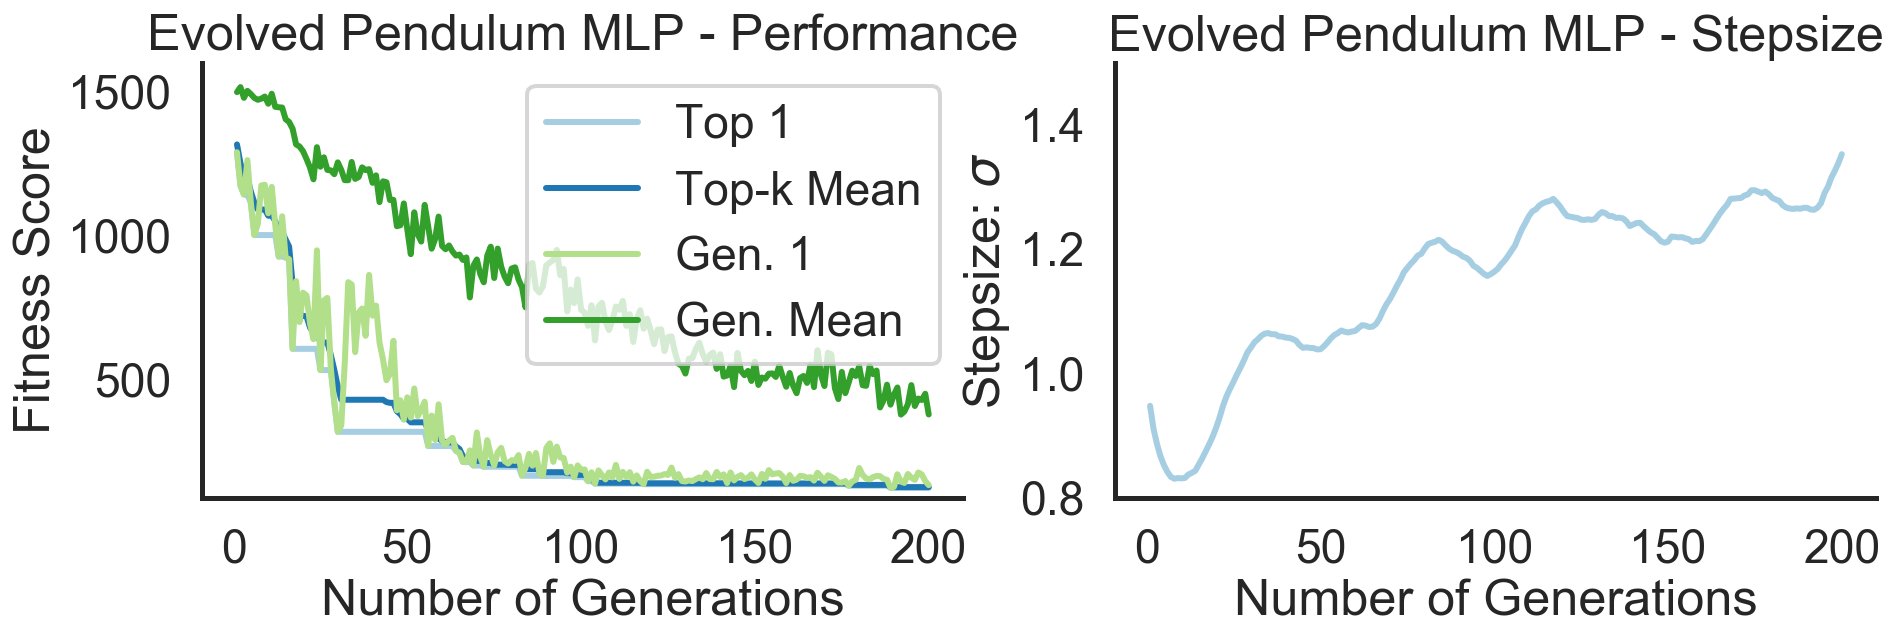

In [17]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
plot_fitness(evo_logger, title="Evolved Pendulum MLP - Performance", ylims=(90, 1600), fig=fig, ax=axs[0])
plot_sigma(evo_logger, title="Evolved Pendulum MLP - Stepsize", ylims=(0.8, 1.5), fig=fig, ax=axs[1])

In the left plot above we see that the strategy is capabale of solving the Pendulum task (fitness score of ca. 120) in less than 50 seconds (on a 2,7 GHz Quad-Core Intel Core i7 chip). The plot shows the overall best performing solution ("Top 1") found so far as well as the mean of the top 5 solutions ("Top-k Mean") across the search iterations. In total we have gone through 200 generations with 100 networks each and evaluated each single one on 50 episodes with 200 sequential steps. A total of 200 million step transitions and 200 network sampling/covariance adaptation steps in less than a minute on a standard CPU. And this even included `jit`-compilation time. Pretty dope if you ask me. Let's now take a look at the evolved behaviors at different stages of the evolutionary trajectory:

![title](img/pendulum_anim.gif)

## A Hyperspace Odyssey for CMA-ES

Something I like to do when there is some extra compute lying around is to figure out when things break. This for me means running grid searches and building some intuition about the 'white-box' dynamics of our algorithm, which may not be directly visible just from starring at the update equations. I was particularly interested in how CMA-ES would scale to larger networks, how the truncation selection ($\lambda > \mu$) would affect the performance as well as how much wiggle room there is with the mean learning rate ($c_m$). Therefore, I ran the same configuration as above but changed the individual parameters. In order to get a little more statistical power, I repeated the experiment over 10 different seeds. In the figure below you can see how the performance varied across these 3 parameters (smaller is better): 

![title](img/hyperparams.png)

1. **Left**: We train simple feedforward policies with a single hidden layer and different hidden dimensions. The final cumulative cost after the adaptive search increases as we increase the capacity of the network. The estimation of $C$ becomes harder and the performance drops. This may get better when increasing the population size at constant absolute truncation strength.
2. **Middle**: The optimal truncation selection for an overall population of 100 is approximately 50%. Less or more elitism decreases the performance. On the one hand, you want to aggressively exploit the newest information of the generation. On the other hand, there is some risk associated with the limited evaluation on only 20 episodes.
3. **Right**: We can choose a fairly large mean learning rate without impairing the performance of the CMA-ES. While the tutorial by Hansen (2016) suggests setting it smaller than 1, we don't see significant performance drops for larger learning rate. This may be due to both our policy as well as objective being deterministic.

## Comparing Single Generation Runtimes across Devices

And last but not least we have to see how hard we can scale this on GPUs. In the figure below you find a runtime (**left**) and compile time (**right**) benchmark for a single `ask`-`eval`-`tell` iteration on the Pendulum task and for different population sizes (and 50 MC fitness evaluations):

![](img/benchmark.png)

The measured times are averaged over 1000 iterations and were obtained on three different devices. We see an increase in time per generations as the population size is increased. Both GPUs, on the other hand, handle the increased population size easily using simple parallelization. But this appears to come with a small caveat: Increased XLA compile time. I am not sure what is going on here but given that you only have to compile once at the first function call, this seems negligible.

# Conclusion & Final Pointers

In this post we learned about the CMA evolutionary strategy and experienced how the power of the `jit`, `vmap` and `lax.scan` combo is capable of scaling neuroevolution methods. With two lines of code we were able to vectorize over both stochastic fitness evaluations and population members. The power of XLA then allowed us to run the entire ask-evaluate-tell procedure on accelerated hardware. Ultimately, these are the types of soft- and hardware developments, which enable new types of research (reminiscient of arguments in the ['Hardware Lottery'](https://hardwarelottery.github.io/) by Sara Hooker) and potentially revive forgotten techniques. Here we investigated one type of gradient-free optimization, which can free us from the requirement of having to use differentiable functions everywhere. E.g. we can use spikes (like the brain does!). In the future, we may dream of entirely different types of neural net architectures, which leverage scalable random search/0-order methods.

--------------

Finally, the entire code of this tutorial can be found in this [repository](https://github.com/RobertTLange/code-and-blog/07_neuroevolution) ready for you to dive in. Furthermore, I put the entire pipeline into a [120 line snippet](https://github.com/RobertTLange/code-and-blog/07_neuroevolution/cma_es_toy.py). I would love to get some feedback ⭐ CMA-ES obviously is not the only ES out there. So if you want to know more about different ES or get a different point of view on CMA-ES, I recommend checking out the following links:

- Nikolaus Hansen's great [tutorial paper on CMA-ES](https://arxiv.org/pdf/1604.00772.pdf) and [documentation page](http://cma.gforge.inria.fr/).
- David Ha's [estool](https://github.com/hardmaru/estool/tree/9a3c40853aa49629386e5b9d98633ffc2979860f) toolbox and the [visual intro to ES](https://blog.otoro.net/2017/10/29/visual-evolution-strategies/).
- Lilian Weng's [blog/survey](https://lilianweng.github.io/lil-log/2019/09/05/evolution-strategies.html) on evolutionary strategies.
- CyberAgents Github repo with a Numpy [CMA-ES implementation](https://github.com/CyberAgent/cmaes).

--------------
I want to thank [Joram Keijser](https://twitter.com/joram_keijser) for helping me make this blog a better version of itself and for being my buddy in JAX-love crime.

<a id='hyperparam_cell'></a>
## Extra: An Overview of Hyperparameters for CMA-ES

We have only glanced over the specifics of how to initialize/set the different parameter initialisation of CMA-ES. This is mainly because I wanted to focus on the high-level intuition and not drown you too much in math. If you want to learn more about how the nitty details I recommend checking out the tutorial by Hansen (2016). Below I have collected a table of key hyperparameters and how they are set in the reference tutorial:

<table width="900">
  <tr>
    <td> Parameter </td>
    <td> Description </td>
    <td> Value Range  </td>
  </tr>
  <tr>
    <td> $\lambda$ </td>
    <td> Population size </td>
    <td> $\lambda \geq 2$ </td>
  </tr>
  <tr>
    <td> $\mu$ </td>
    <td> Parent number/"Elite" </td>
    <td> $\mu \leq \lambda$ </td>
  </tr>
  <tr>
    <td> $w_i$ </td>
    <td> Recombination weights </td>
    <td> $w_i \geq 0, i \leq \mu$ </td>
  </tr>
  <tr>
    <td> $\mu_{eff}$ </td>
    <td> Variance effective selection mass for mean </td>
    <td>  </td>
  </tr>
  <tr>
    <td> $\sigma^{(0)}$ </td>
    <td> Stepsize </td>
    <td> $\mathbb{R}_+$ </td>
  </tr>
  <tr>
    <td> $c_c$ </td>
    <td> LRate for cumulation for rank-one update </td>
    <td> $\leq 1$ </td>
  </tr>
  <tr>
    <td> $c_1$ </td>
    <td> LRate for rank-one update </td>
    <td> $\leq 1 - c_\mu$ </td>
  </tr>
  <tr>
    <td> $c_\mu$ </td>
    <td> LRate for rank-$\mu$ update </td>
    <td> $\leq 1 - c_1$ </td>
  </tr>
  <tr>
    <td> $c_\sigma$ </td>
    <td> Lrate for cumulation for stepsize update </td>
    <td> $\leq 1$ </td>
  </tr>
  <tr>
    <td> $d_\sigma$ </td>
    <td> Damping parameter stepsize update </td>
    <td> $\leq 1$ </td>
  </tr>
</table>